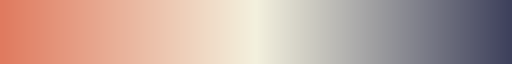

In [8]:
from scipy import odr
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as mcolors
import plotly.express as px, plotly.graph_objects as go
import os
import sys
import seaborn as sns
from matplotlib.colors import to_rgba
from scipy.stats import pearsonr

%matplotlib inline

original_sys_path = sys.path.copy()
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from hrdtimer import utils as HRDTimerUtils
sys.path = original_sys_path

pd.options.mode.chained_assignment = None

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  

# Define a custom color palette (e.g., from red to yellow to green)
colors = ["#e07a5f", "#f4f1de", "#3d405b"]  # Red -> Yellow -> Green

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap

## Compare pi1 estimates (SBS3 vs SBS1) across all datasets

#### Proportion of late out of all SBS3 mutations (π₁⁽ˢᵇˢ³⁾) plotted against the proportion of late among all SBS1 mutations (π₁⁽ˢᵇˢ¹⁾)

This analysis indicates that SBS3 is:

1. Relatively more active post-WGD (late)  
2. Also active early, as captured by π₂ = 1 − π₁


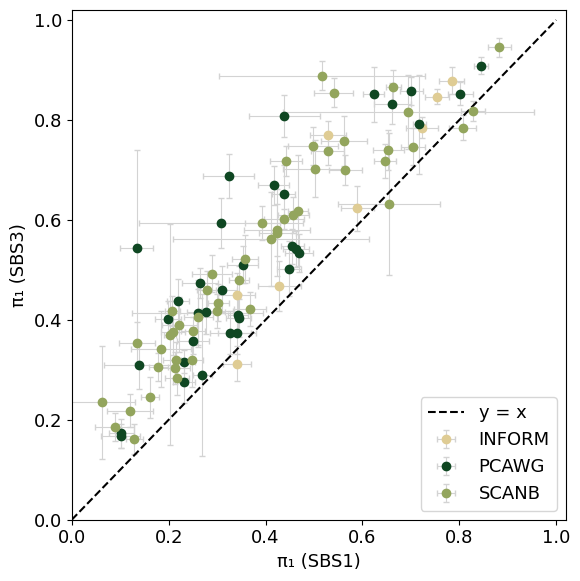

In [2]:
files = {
    'SCANB': "../../data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv",
    'PCAWG': "../../data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv",
    'INFORM': "../../data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv"
}

outlier_samples = []  # Add outlier sample IDs if needed

def parse_list(s):
    arr = np.array(eval(s, {"nan": np.nan}), dtype=float)
    return arr[[0, 2]] if len(arr) == 3 else arr

def weighted_mean_and_propagated_error(values, errors, weights):
    values, errors, weights = map(np.array, (values, errors, weights))
    mask = ~np.isnan(values)
    if not np.any(mask): return np.nan, np.nan
    values, errors, weights = values[mask], errors[mask], weights[mask]
    mean = np.average(values, weights=weights)
    error = np.sqrt(np.sum((weights * errors) ** 2) / np.sum(weights) ** 2)
    return mean, error

records = []
for label, path in files.items():
    df = pd.read_csv(path)
    df = df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'pi1SBS1_ci', 'pi1SBS3_ci', 'N_mut_all'])
    for _, row in df.iterrows():
        if row['ID'] in outlier_samples:
            continue
        weights = parse_list(row['N_mut_all'])
        m1, e1 = weighted_mean_and_propagated_error(parse_list(row['pi1SBS1']), parse_list(row['pi1SBS1_ci']), weights)
        m3, e3 = weighted_mean_and_propagated_error(parse_list(row['pi1SBS3']), parse_list(row['pi1SBS3_ci']), weights)
        records.append({
            'ID': row['ID'], 'Dataset': label,
            'SBS1': m1, 'SBS1_err': e1,
            'SBS3': m3, 'SBS3_err': e3
        })

plot_df = pd.DataFrame(records)
plot_df.to_csv("../../data/output/All_Cohorts_pi1SBS3_vs_pi1SBS1_CN_20_22.csv", index=False)

# Plot
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}
plt.figure(figsize=(6, 6))
for d, sub in plot_df.groupby('Dataset'):
    plt.errorbar(sub['SBS1'], sub['SBS3'], xerr=sub['SBS1_err'], yerr=sub['SBS3_err'],
                 fmt='o', label=d, color=colors[d], ecolor='lightgrey', capsize=2,
                 markersize=6, elinewidth=0.8)

x = np.linspace(0, 1, 100)
plt.plot(x, x, 'k--', label='y = x')
plt.xlabel("π₁ (SBS1)")
plt.ylabel("π₁ (SBS3)")
plt.xlim(0, 1.02)
plt.ylim(0, 1.02)
plt.legend()
plt.tight_layout()
plt.savefig("../../data/output/output_plots/All_Cohorts_pi1SBS3_vs_pi1SBS1_CN_20_22.pdf", format='pdf', bbox_inches='tight')
plt.show()


## Compare early and late SBS3 vs SBS1 correlation across cohorts

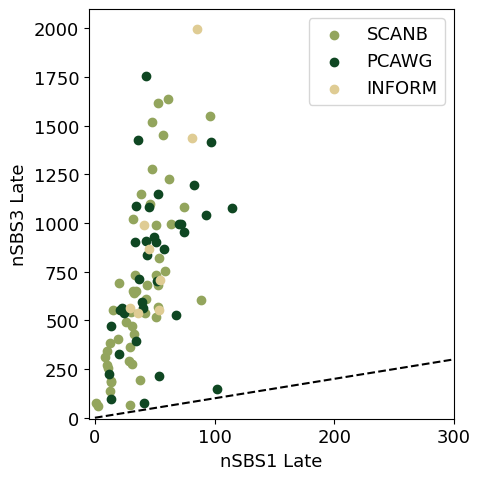

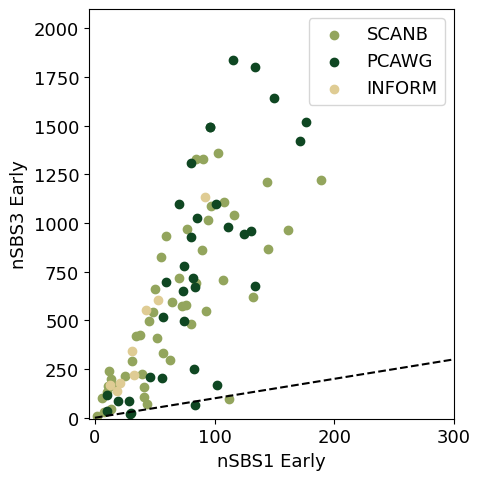

In [3]:
def parse_list(s):
    return np.array(eval(s, {"nan": np.nan}), dtype=float)

def keep_first_and_third(arr):
    if len(arr) < 3:
        # If less than 3 elements, just return what you have (or np.nan)
        return arr
    # Keep only 1st and 3rd (index 0 and 2)
    return np.array([arr[0], arr[2]])

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'Nt_SBS1', 'Nt_SBS3', 'pi2SBS1', 'pi2SBS3']).iterrows():
        # Parse arrays
        pi1_sbs1 = keep_first_and_third(parse_list(row['pi1SBS1']))
        pi1_sbs3 = keep_first_and_third(parse_list(row['pi1SBS3']))
        nt_sbs1 = keep_first_and_third(parse_list(row['Nt_SBS1']))
        nt_sbs3 = keep_first_and_third(parse_list(row['Nt_SBS3']))

        pi2_sbs1 = keep_first_and_third(parse_list(row['pi2SBS1']))
        pi2_sbs3 = keep_first_and_third(parse_list(row['pi2SBS3']))

        # nt arrays are same for pi1 and pi2, reusing nt_sbs1 and nt_sbs3

        # Masks for valid (non-nan) entries
        sbs1_mask_late = ~np.isnan(pi1_sbs1) & ~np.isnan(nt_sbs1)
        sbs3_mask_late = ~np.isnan(pi1_sbs3) & ~np.isnan(nt_sbs3)

        sbs1_mask_early = ~np.isnan(pi2_sbs1) & ~np.isnan(nt_sbs1)
        sbs3_mask_early = ~np.isnan(pi2_sbs3) & ~np.isnan(nt_sbs3)

        # Compute weighted sums
        sbs1_total_late = np.sum(pi1_sbs1[sbs1_mask_late] * nt_sbs1[sbs1_mask_late])
        sbs3_total_late = np.sum(pi1_sbs3[sbs3_mask_late] * nt_sbs3[sbs3_mask_late])

        sbs1_total_early = np.sum(pi2_sbs1[sbs1_mask_early] * nt_sbs1[sbs1_mask_early])
        sbs3_total_early = np.sum(pi2_sbs3[sbs3_mask_early] * nt_sbs3[sbs3_mask_early])

        records.append({
            'Dataset': label,
            'SBS1_Late': sbs1_total_late,
            'SBS3_Late': sbs3_total_late,
            'SBS1_Early': sbs1_total_early,
            'SBS3_Early': sbs3_total_early
        })

plot_df = pd.DataFrame(records)
plot_df.to_csv("../../data/output/All_Cohorts_SBS1_SBS3_Late_Early.csv", index=False)

# Plotting Late
plt.figure(figsize=(5, 5))
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.scatter(sub['SBS1_Late'], sub['SBS3_Late'], label=d, color=colors[d], alpha=1)

plt.xlim(-5, 300)
plt.ylim(-5, 2100)
plt.plot([0, 300], [0, 300], 'k--')
plt.xlabel("nSBS1 Late")
plt.ylabel("nSBS3 Late")
plt.legend()
plt.tight_layout()
plt.savefig("../../data/output/output_plots/All_Cohorts_Late_SBS3_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Plotting Early
plt.figure(figsize=(5, 5))

for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.scatter(sub['SBS1_Early'], sub['SBS3_Early'], label=d, color=colors[d], alpha=1)

plt.xlim(-5, 300)
plt.ylim(-5, 2100)
plt.plot([0, 300], [0, 300], 'k--')
plt.xlabel("nSBS1 Early")
plt.ylabel("nSBS3 Early")
plt.legend()
plt.tight_layout()
plt.savefig("../../data/output/output_plots/All_Cohorts_Early_SBS3_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()


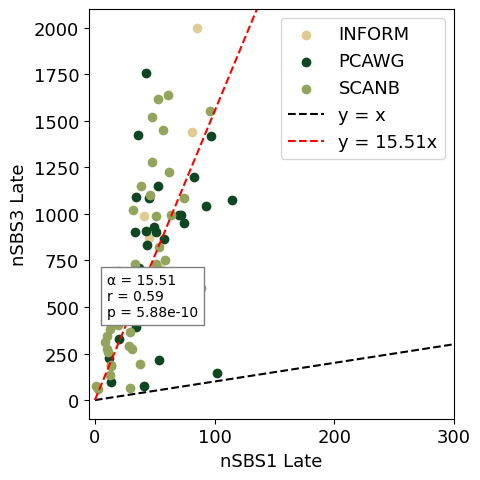

In [4]:
x = plot_df['SBS1_Late']
y = plot_df['SBS3_Late']

mask = ~np.isnan(x) & ~np.isnan(y)
x, y = x[mask], y[mask]

alpha = np.sum(x * y) / np.sum(x ** 2)
fitted = alpha * x
r, p = pearsonr(x, y)

# Plot
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}
plt.figure(figsize=(5, 5))
for d, sub in plot_df.groupby('Dataset'):
    xt = sub['SBS1_Late']
    yt = sub['SBS3_Late']
    plt.scatter(xt, yt, label=d, color=colors[d])

plt.plot([0, 500], [0, 500], 'k--', label='y = x')
plt.plot([0, 500], [0, alpha * 500], 'r--', label=f'y = {alpha:.2f}x')
plt.text(10, 450, f"α = {alpha:.2f}\nr = {r:.2f}\np = {p:.2e}", fontsize=10,
         bbox=dict(facecolor='white', edgecolor='gray'))

plt.xlabel("nSBS1 Late")
plt.ylabel("nSBS3 Late")
plt.xlim(-5, 300)
plt.ylim(-100, 2100)
plt.legend()
plt.tight_layout()
plt.show()


## Compare SBS1 exposures vs C>T substitutions at CpG contexts

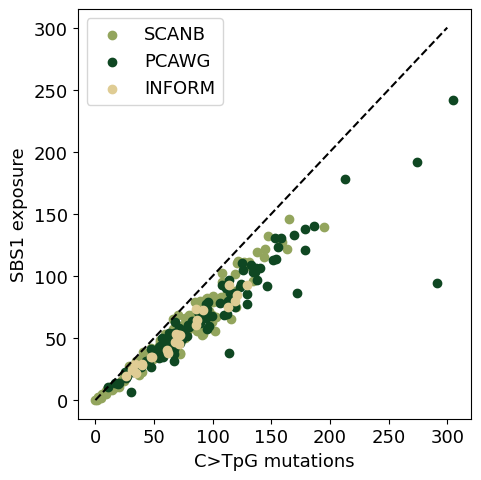

In [5]:
def parse_list(s): return np.array(eval(s, {"nan": np.nan}), dtype=float)

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['Nt_SBS1', 'N_mut(C>TpG)']).iterrows():
        nt_sbs1 = parse_list(row['Nt_SBS1'])
        ctpG = parse_list(row['N_mut(C>TpG)'])

        for x, y in zip(nt_sbs1, ctpG):
            records.append({
                'Dataset': label,
                'Nt_SBS1': x,
                'N_mut(C>TpG)': y
            })

plot_df = pd.DataFrame(records)

# Plotting
plt.figure(figsize=(5, 5))
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.scatter(sub['N_mut(C>TpG)'],sub['Nt_SBS1'], label=d, color=colors[d], alpha=1)

plt.plot([0,300], [0,300], 'k--')
plt.ylabel("SBS1 exposure")
plt.xlabel("C>TpG mutations")
plt.legend()
plt.tight_layout()
plt.savefig("../../data/output/output_plots/All_cohorts_CpG_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Investigate how probability of assignment of a C>T substitution at CpG contexts vary across cohorts and time points (early vs late)

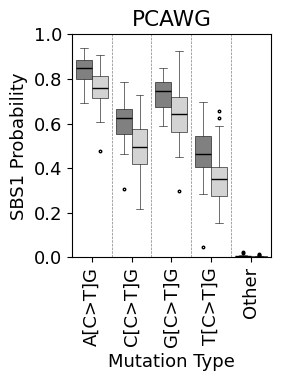

In [9]:
HRDTimerUtils.plot_sbs1_CpG_boxplot(
    cohort='PCAWG',
    sample_ids_csv_path='../../data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv',
    base_dir='../../HRDTimer_PreProcess/PCAWG/Breast/timing/SignatureFitting',
    output_path='../../data/output/output_plots/SBS1_PCAWG_prob.pdf'
)

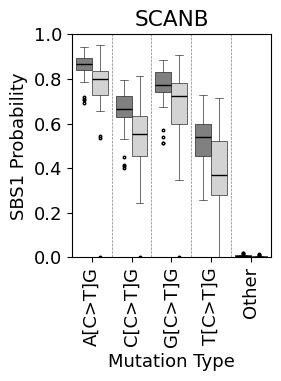

In [10]:
HRDTimerUtils.plot_sbs1_CpG_boxplot(
    cohort='SCANB',
    sample_ids_csv_path='../../data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv',
    base_dir='../../HRDTimer_PreProcess/SCANB/Breast/timing/SignatureFitting',
    output_path='../../data/output/output_plots/SBS1_SCANB_prob.pdf'
)

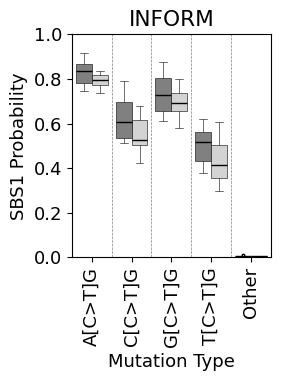

In [11]:
HRDTimerUtils.plot_sbs1_CpG_boxplot(
    cohort='INFORM',
    sample_ids_csv_path='../../data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv',
    base_dir='../../HRDTimer_PreProcess/INFORM/Breast/timing/SignatureFitting',
    output_path='../../data/output/output_plots/SBS1_INFORM_prob.pdf'
)